# Data processing

## Imports

In [3]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
from datetime import timedelta, date, datetime

import warnings

warnings.filterwarnings("ignore")

## Data

In [4]:
# The dataframe is available on
# https://github.com/owid/covid-19-data
# https://www.kaggle.com/gpreda/covid-world-vaccination-progress
# The original dataframe contains 104214 observations of 16 parameters.
# For this project only 8 parameters were subsetted and used

In [5]:
# Download data from Github
data_table = pd.read_csv(
    "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv"
)

In [6]:
data_table = data_table[
    [
        "location",
        "date",
        "total_vaccinations",
        "people_vaccinated",
        "people_fully_vaccinated",
        "total_vaccinations_per_hundred",
        "people_vaccinated_per_hundred",
        "people_fully_vaccinated_per_hundred",
    ]
].rename(columns={"location": "country"})

In [7]:
data_table = data_table[data_table["date"] < "2022-01-01"]

In [8]:
data_table.head(1)

,country,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred
0,Afghanistan,2021-02-22,0.0,0.0,NaN,0.0,0.0,NaN


In [9]:
# List of all countries and continents
countries = data_table.country.unique().tolist()
len(countries)

235

## Filtering

### from countries with sparse data

In [10]:
data_table["total"] = np.nan

In [11]:
# the main feature is people_fully_vaccinated_per_hundred
nan_stats = (
    data_table[["people_fully_vaccinated_per_hundred", "total"]]
    .isnull()
    .groupby([data_table["country"]])
    .sum()
    .astype(int)
    # .reset_index(name="count")
)
nan_stats["nan_ratio"] = round(
    nan_stats["people_fully_vaccinated_per_hundred"] / nan_stats["total"] * 100, 1
)

In [12]:
nan_stats = nan_stats[nan_stats["nan_ratio"] < 60]

In [13]:
nan_stats[nan_stats.index == "Serbia"]

,people_fully_vaccinated_per_hundred,total,nan_ratio
country,,,
Serbia,180,358,50.3


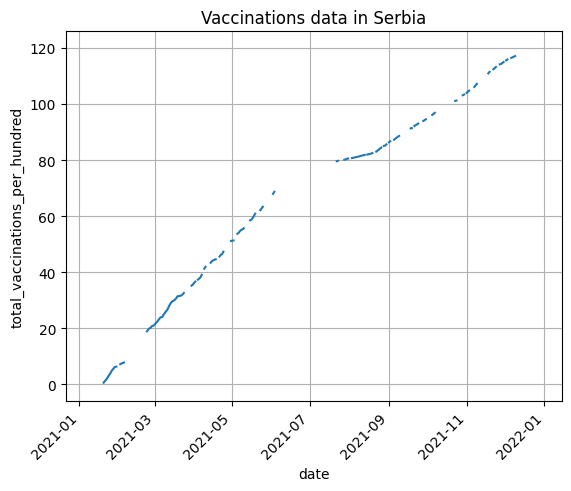

In [14]:
sample = data_table[data_table["country"] == "Serbia"]
plt.plot(pd.to_datetime(sample["date"]), sample["total_vaccinations_per_hundred"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("date")
plt.ylabel("total_vaccinations_per_hundred")
plt.title("Vaccinations data in Serbia")
plt.grid()

In [15]:
data_table = data_table[data_table["country"].isin(nan_stats.index.to_list())].drop(
    columns="total"
)

### from continents/groups

In [20]:
groups = (
    "Asia",
    "Europe",
    "European Union",
    "Upper middle income",
    "Lower middle income",
    "World",
    "South America",
    "North America",
    "Africa",
)

In [22]:
data_table = data_table[~data_table["country"].isin(groups)]

## Filling missing values

It is unlikely that vaccination rates can drasticaly change between two points of data entry.  
Therefore, it seems logical to fill missing values with linear interpolation.

In [24]:
# Filling missing values with data using linear approximation

for country in countries:
    data_table.loc[data_table["country"] == country] = data_table.loc[
        data_table["country"] == country
    ].interpolate(method="linear")

In [25]:
# there still might be nans
# I will only need data of people_fully_vaccinated_per_hundred
data_table = data_table[data_table.people_fully_vaccinated_per_hundred.notna()]

In [26]:
data_table.isna().sum()

country                                0
date                                   0
total_vaccinations                     0
people_vaccinated                      0
people_fully_vaccinated                0
total_vaccinations_per_hundred         0
people_vaccinated_per_hundred          0
people_fully_vaccinated_per_hundred    0
dtype: int64

## save processed data

In [27]:
data_table.to_parquet("../data/processed_data.parquet")

## Results

- many countries have sparse data, however even 50% of missing values shows clear trend 
- interpolated missing values fit perfectly with linear method